In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seemamore","key":"d99a9b4e6fcb4544625732d67db549ff"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download cdminix/us-drought-meteorological-data

100% 899M/901M [00:48<00:00, 22.5MB/s]
100% 901M/901M [00:48<00:00, 19.6MB/s]


In [ ]:
!unzip us-drought-meteorological-data.zip

Archive:  us-drought-meteorological-data.zip
  inflating: soil_data.csv           
  inflating: test_timeseries/test_timeseries.csv  
  inflating: train_timeseries/train_timeseries.csv  
  inflating: validation_timeseries/validation_timeseries.csv  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow.keras as keras
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Flatten
from keras.layers import concatenate

In [ ]:
train_data = pd.read_csv('train_timeseries/train_timeseries.csv')

In [ ]:
data = pd.read_csv('soil_data.csv')

In [ ]:
train_data = train_data[train_data['date'] <= '2013-12-31']

In [ ]:
result = pd.merge(train_data, data, on='fips', how='inner')
result

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15894307,56043,2013-12-27,0.06,83.42,3.04,-1.22,-5.47,-5.43,5.90,-5.29,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15894308,56043,2013-12-28,0.72,83.17,2.17,-5.22,-9.73,-9.61,-0.86,-12.02,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15894309,56043,2013-12-29,0.20,83.17,1.69,-8.08,-12.21,-12.08,-1.21,-13.51,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15894310,56043,2013-12-30,0.04,83.18,2.30,-3.98,-8.74,-8.66,2.40,-8.74,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [ ]:
result =  result.drop(['score'], axis=1)

In [ ]:
#grouped_result = result.groupby(['date', 'fips']).sum().reset_index()
#grouped_result

In [ ]:
#grouped_result['date'].nunique()

In [ ]:
result['date'].nunique()

5114

In [ ]:
train = result[(result['date'] >= '2000-01-01') & (result['date'] <= '2008-12-31')]
validation = result[(result['date'] >= '2009-01-01') & (result['date'] <= '2010-12-31')]
test = result[(result['date'] >= '2011-01-01') & (result['date'] <= '2012-12-31')]

In [ ]:
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
train['date'] = pd.to_datetime(train['date'])


train['Year'] = train['date'].dt.year
train['Month'] = train['date'].dt.month
train['Day'] = train['date'].dt.day

train = train.drop(columns=['date'])
train

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,Year,Month,Day
0,1001,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,9.50,...,1,1,1,1,1,1,2,2000,1,1
1,1001,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,10.18,...,1,1,1,1,1,1,2,2000,1,2
2,1001,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,7.41,...,1,1,1,1,1,1,2,2000,1,3
3,1001,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,...,1,1,1,1,1,1,2,2000,1,4
4,1001,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,13.48,...,1,1,1,1,1,1,2,2000,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10219099,56043,0.70,82.31,1.47,-10.39,-14.50,-14.23,-2.84,-16.79,13.95,...,1,1,1,1,1,1,1,2008,12,27
10219100,56043,0.28,82.80,2.66,-4.52,-7.41,-7.37,2.14,-9.60,11.74,...,1,1,1,1,1,1,1,2008,12,28
10219101,56043,0.36,82.77,3.35,-1.00,-4.38,-4.36,4.18,-5.80,9.98,...,1,1,1,1,1,1,1,2008,12,29
10219102,56043,1.08,83.28,1.71,-4.75,-12.42,-12.11,2.01,-10.46,12.46,...,1,1,1,1,1,1,1,2008,12,30


In [ ]:
validation['date'] = pd.to_datetime(validation['date'])


validation['Year'] = validation['date'].dt.year
validation['Month'] = validation['date'].dt.month
validation['Day'] = validation['date'].dt.day

validation = validation.drop(columns=['date'])
validation

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,Year,Month,Day
0,1001,0.01,100.69,3.66,3.63,-0.75,-0.72,11.42,-3.64,15.06,...,1,1,1,1,1,1,2,2009,1,1
1,1001,2.71,100.15,7.29,9.71,8.96,8.96,13.03,5.97,7.06,...,1,1,1,1,1,1,2,2009,1,2
2,1001,9.09,100.12,10.66,15.36,14.91,14.91,19.45,11.91,7.54,...,1,1,1,1,1,1,2,2009,1,3
3,1001,6.31,100.37,10.56,15.55,14.88,14.88,19.34,13.36,5.98,...,1,1,1,1,1,1,2,2009,1,4
4,1001,18.56,100.17,11.01,16.24,15.44,15.44,19.49,12.75,6.74,...,1,1,1,1,1,1,2,2009,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268835,56043,0.00,83.02,1.95,-4.33,-10.64,-10.47,2.10,-8.03,10.12,...,1,1,1,1,1,1,1,2010,12,27
2268836,56043,0.03,82.35,2.08,-5.43,-10.13,-10.01,1.07,-10.15,11.22,...,1,1,1,1,1,1,1,2010,12,28
2268837,56043,1.26,80.57,2.93,-1.48,-6.29,-6.24,3.36,-5.36,8.72,...,1,1,1,1,1,1,1,2010,12,29
2268838,56043,3.67,81.43,1.15,-12.76,-16.88,-16.48,-6.34,-17.29,10.94,...,1,1,1,1,1,1,1,2010,12,30


In [ ]:
test['date'] = pd.to_datetime(test['date'])


test['Year'] = test['date'].dt.year
test['Month'] = test['date'].dt.month
test['Day'] = test['date'].dt.day

test = test.drop(columns=['date'])
test

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,Year,Month,Day
0,1001,40.22,100.10,8.99,13.17,12.08,12.08,17.51,7.61,9.90,...,1,1,1,1,1,1,2,2011,1,1
1,1001,0.02,100.85,3.34,3.48,-2.08,-2.01,8.69,-3.74,12.43,...,1,1,1,1,1,1,2,2011,1,2
2,1001,0.00,100.93,2.60,2.19,-5.02,-4.91,10.40,-6.08,16.48,...,1,1,1,1,1,1,2,2011,1,3
3,1001,0.05,100.53,3.67,6.28,-0.59,-0.55,13.98,0.18,13.80,...,1,1,1,1,1,1,2,2011,1,4
4,1001,4.24,99.86,5.88,6.97,5.78,5.79,10.42,2.27,8.15,...,1,1,1,1,1,1,2,2011,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271943,56043,1.33,82.23,1.76,-8.43,-11.79,-11.67,-4.52,-10.35,5.83,...,1,1,1,1,1,1,1,2012,12,27
2271944,56043,0.08,82.80,1.53,-8.00,-13.29,-13.07,-1.95,-11.53,9.58,...,1,1,1,1,1,1,1,2012,12,28
2271945,56043,0.01,82.92,1.29,-10.03,-15.05,-14.77,-3.07,-15.59,12.52,...,1,1,1,1,1,1,1,2012,12,29
2271946,56043,0.02,82.83,1.37,-9.48,-14.42,-14.16,-2.66,-13.37,10.71,...,1,1,1,1,1,1,1,2012,12,30


In [ ]:
dynamic_columns = ['Year', 'Month', 'Day', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS', 'WS10M', 'WS10M_MAX','WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']  #dynamic features

In [ ]:
dynamic_columns

['Year',
 'Month',
 'Day',
 'PS',
 'QV2M',
 'T2M',
 'T2MDEW',
 'T2MWET',
 'T2M_MAX',
 'T2M_MIN',
 'T2M_RANGE',
 'TS',
 'WS10M',
 'WS10M_MAX',
 'WS10M_MIN',
 'WS10M_RANGE',
 'WS50M',
 'WS50M_MAX',
 'WS50M_MIN',
 'WS50M_RANGE']

In [ ]:
y_train = train['PRECTOT']
y_train

0            0.22
1            0.20
2            3.65
3           15.95
4            0.00
            ...  
10219099     0.70
10219100     0.28
10219101     0.36
10219102     1.08
10219103     0.54
Name: PRECTOT, Length: 10219104, dtype: float64

In [ ]:
y_valid = validation['PRECTOT']
y_valid

0           0.01
1           2.71
2           9.09
3           6.31
4          18.56
           ...  
2268835     0.00
2268836     0.03
2268837     1.26
2268838     3.67
2268839     0.77
Name: PRECTOT, Length: 2268840, dtype: float64

In [ ]:
y_test = test['PRECTOT']
y_test

0          40.22
1           0.02
2           0.00
3           0.05
4           4.24
           ...  
2271943     1.33
2271944     0.08
2271945     0.01
2271946     0.02
2271947     0.01
Name: PRECTOT, Length: 2271948, dtype: float64

In [ ]:
train = train.drop(columns=['PRECTOT'])
validation = validation.drop(columns=['PRECTOT'])
test = test.drop(columns=['PRECTOT'])

In [ ]:
dynamic_train = train[dynamic_columns] #seperate dynamic features
dynamic_train

,Year,Month,Day,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,2000,1,1,100.51,9.65,14.74,13.51,13.51,20.96,11.46,9.50,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81
1,2000,1,2,100.55,10.42,16.69,14.71,14.71,22.80,12.61,10.18,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41
2,2000,1,3,100.15,11.76,18.49,16.52,16.52,22.73,15.32,7.41,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66
3,2000,1,4,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58
4,2000,1,5,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,13.48,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10219099,2008,12,27,82.31,1.47,-10.39,-14.50,-14.23,-2.84,-16.79,13.95,-12.92,4.23,5.29,2.87,2.43,6.19,7.66,4.25,3.41
10219100,2008,12,28,82.80,2.66,-4.52,-7.41,-7.37,2.14,-9.60,11.74,-6.26,5.65,7.75,4.19,3.55,8.59,9.63,7.34,2.30
10219101,2008,12,29,82.77,3.35,-1.00,-4.38,-4.36,4.18,-5.80,9.98,-2.90,7.62,12.24,4.11,8.13,11.32,17.66,6.97,10.69
10219102,2008,12,30,83.28,1.71,-4.75,-12.42,-12.11,2.01,-10.46,12.46,-6.65,6.06,12.57,2.33,10.24,8.87,17.68,3.82,13.86


In [ ]:
dynamic_valid = validation[dynamic_columns] #seperate dynamic features
dynamic_valid

,Year,Month,Day,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,2009,1,1,100.69,3.66,3.63,-0.75,-0.72,11.42,-3.64,15.06,3.69,2.57,3.82,1.82,2.00,5.10,6.62,4.17,2.45
1,2009,1,2,100.15,7.29,9.71,8.96,8.96,13.03,5.97,7.06,9.31,1.51,2.53,0.24,2.29,2.85,5.03,0.38,4.65
2,2009,1,3,100.12,10.66,15.36,14.91,14.91,19.45,11.91,7.54,15.24,2.17,2.83,1.82,1.01,4.82,5.91,3.50,2.41
3,2009,1,4,100.37,10.56,15.55,14.88,14.88,19.34,13.36,5.98,15.39,1.70,1.96,1.12,0.85,3.63,4.77,2.03,2.74
4,2009,1,5,100.17,11.01,16.24,15.44,15.44,19.49,12.75,6.74,16.11,1.98,4.01,0.54,3.47,4.06,7.64,1.10,6.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268835,2010,12,27,83.02,1.95,-4.33,-10.64,-10.47,2.10,-8.03,10.12,-6.26,4.08,6.90,2.39,4.51,6.39,8.52,3.75,4.77
2268836,2010,12,28,82.35,2.08,-5.43,-10.13,-10.01,1.07,-10.15,11.22,-6.70,4.55,6.31,2.68,3.63,6.89,9.48,4.39,5.09
2268837,2010,12,29,80.57,2.93,-1.48,-6.29,-6.24,3.36,-5.36,8.72,-2.66,5.22,8.11,1.26,6.85,7.25,11.04,2.30,8.74
2268838,2010,12,30,81.43,1.15,-12.76,-16.88,-16.48,-6.34,-17.29,10.94,-11.67,4.79,5.88,3.68,2.20,5.70,6.95,4.13,2.81


In [ ]:
dynamic_test = test[dynamic_columns] #seperate dynamic features
dynamic_test

,Year,Month,Day,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,2011,1,1,100.10,8.99,13.17,12.08,12.08,17.51,7.61,9.90,13.04,3.44,4.77,1.99,2.78,6.22,8.63,3.25,5.38
1,2011,1,2,100.85,3.34,3.48,-2.08,-2.01,8.69,-3.74,12.43,3.45,2.93,4.45,1.90,2.55,5.47,6.77,4.59,2.18
2,2011,1,3,100.93,2.60,2.19,-5.02,-4.91,10.40,-6.08,16.48,0.54,1.23,2.28,0.19,2.09,2.32,4.72,0.23,4.49
3,2011,1,4,100.53,3.67,6.28,-0.59,-0.55,13.98,0.18,13.80,4.16,1.64,2.30,0.72,1.58,2.51,3.74,1.22,2.52
4,2011,1,5,99.86,5.88,6.97,5.78,5.79,10.42,2.27,8.15,6.39,1.82,2.84,0.13,2.70,3.49,5.89,0.21,5.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271943,2012,12,27,82.23,1.76,-8.43,-11.79,-11.67,-4.52,-10.35,5.83,-9.06,3.48,4.97,1.72,3.25,4.51,5.77,2.93,2.84
2271944,2012,12,28,82.80,1.53,-8.00,-13.29,-13.07,-1.95,-11.53,9.58,-10.04,2.96,5.31,1.86,3.45,4.41,6.46,2.97,3.49
2271945,2012,12,29,82.92,1.29,-10.03,-15.05,-14.77,-3.07,-15.59,12.52,-11.64,2.99,4.06,1.63,2.43,4.43,5.41,2.67,2.74
2271946,2012,12,30,82.83,1.37,-9.48,-14.42,-14.16,-2.66,-13.37,10.71,-10.99,1.75,2.86,0.80,2.06,2.52,4.82,0.83,3.99


In [ ]:
static_train = train.drop(columns=dynamic_columns) #seperate static features
static_train

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10219099,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
10219100,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
10219101,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
10219102,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [ ]:
static_valid = validation.drop(columns=dynamic_columns) #seperate static features
static_valid

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268835,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2268836,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2268837,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2268838,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [ ]:
static_test = test.drop(columns=dynamic_columns) #seperate static features
static_test

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271943,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2271944,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2271945,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2271946,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [ ]:
static_input = Input(shape=(32,))

static_model = Dense(64, activation='relu')(static_input)
static_model = Dense(32, activation='relu')(static_model)

static_output = Dense(1)(static_model)

static_model = Model(inputs=static_input, outputs=static_output)

In [ ]:
dynamic_train = np.array(dynamic_train)
dynamic_valid = np.array(dynamic_valid)
dynamic_test = np.array(dynamic_test)

# Reshape the data into the format (samples, timesteps, features)
train_dynamic = dynamic_train.reshape((dynamic_train.shape[0], 1, 20))
val_dynamic = dynamic_valid.reshape((dynamic_valid.shape[0], 1, 20))
test_dynamic = dynamic_test.reshape((dynamic_test.shape[0], 1, 20))

# Define the dynamic input
dynamic_input = Input(shape=(1, 20))

# LSTM layers for the dynamic data
dynamic_model = LSTM(64, return_sequences=True)(dynamic_input)
dynamic_model = LSTM(32)(dynamic_model)

# The output layer
dynamic_output = Dense(1, activation='linear')(dynamic_model)

dynamic_model = Model(inputs=dynamic_input, outputs=dynamic_output)

In [ ]:
# Combined input is the concatenation of the static and dynamic parts
combined_input = concatenate([static_model.output, dynamic_model.output])

combined_model = Dense(64, activation='relu')(combined_input)
combined_model = Dense(32, activation='relu')(combined_model)

# Final output layer
output = Dense(1, activation='linear')(combined_model)

# The final model takes as input the static and dynamic inputs and gives a single output
final_model = Model(inputs=[static_model.input, dynamic_model.input], outputs=output)

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=6)

In [ ]:
final_model.compile(optimizer='adam', loss='mean_absolute_error')

history_1 = final_model.fit([static_train, train_dynamic], y_train, validation_data=([static_valid, val_dynamic], y_valid), epochs=20, batch_size=32, callbacks=callback)

Epoch 1/20
319347/319347 [==============================] - 1669s 5ms/step - loss: 2.5746 - val_loss: 2.7910
Epoch 2/20
319347/319347 [==============================] - 1666s 5ms/step - loss: 2.5655 - val_loss: 2.7903
Epoch 3/20
319347/319347 [==============================] - 1662s 5ms/step - loss: 2.5654 - val_loss: 2.7910
Epoch 4/20
319347/319347 [==============================] - 1685s 5ms/step - loss: 2.5655 - val_loss: 2.7903
Epoch 5/20
319347/319347 [==============================] - 1659s 5ms/step - loss: 2.5655 - val_loss: 2.7909
Epoch 6/20
319347/319347 [==============================] - 1652s 5ms/step - loss: 2.5654 - val_loss: 2.7901
Epoch 7/20
319347/319347 [==============================] - 1673s 5ms/step - loss: 2.5655 - val_loss: 2.7903
Epoch 8/20
319347/319347 [==============================] - 1677s 5ms/step - loss: 2.5655 - val_loss: 2.7910
Epoch 9/20
319347/319347 [==============================] - 1662s 5ms/step - loss: 2.5655 - val_loss: 2.7916
Epoch 10/20
319347/

In [ ]:
test_loss = final_model.evaluate([static_test, test_dynamic], y_test)

70999/70999 [==============================] - 171s 2ms/step - loss: 2.4900


In [ ]:
test_predictions = final_model.predict([static_test,  test_dynamic])

70999/70999 [==============================] - 151s 2ms/step


In [ ]:
#Define function for plotting loss
def plot_loss(history, model_name):
    model_history = pd.DataFrame(history.history)
    model_history['epoch'] = history.epoch

    fig, ax = plt.subplots(2,1, figsize=(12,8))

    # Plot training loss
    ax[0].semilogy(model_history['epoch'], model_history['loss'], label='Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title(f'{model_name} Training Loss')
    ax[0].legend()

    # Plot validation loss
    ax[1].semilogy(model_history['epoch'], model_history['val_loss'], label='Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title(f'{model_name} Validation Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

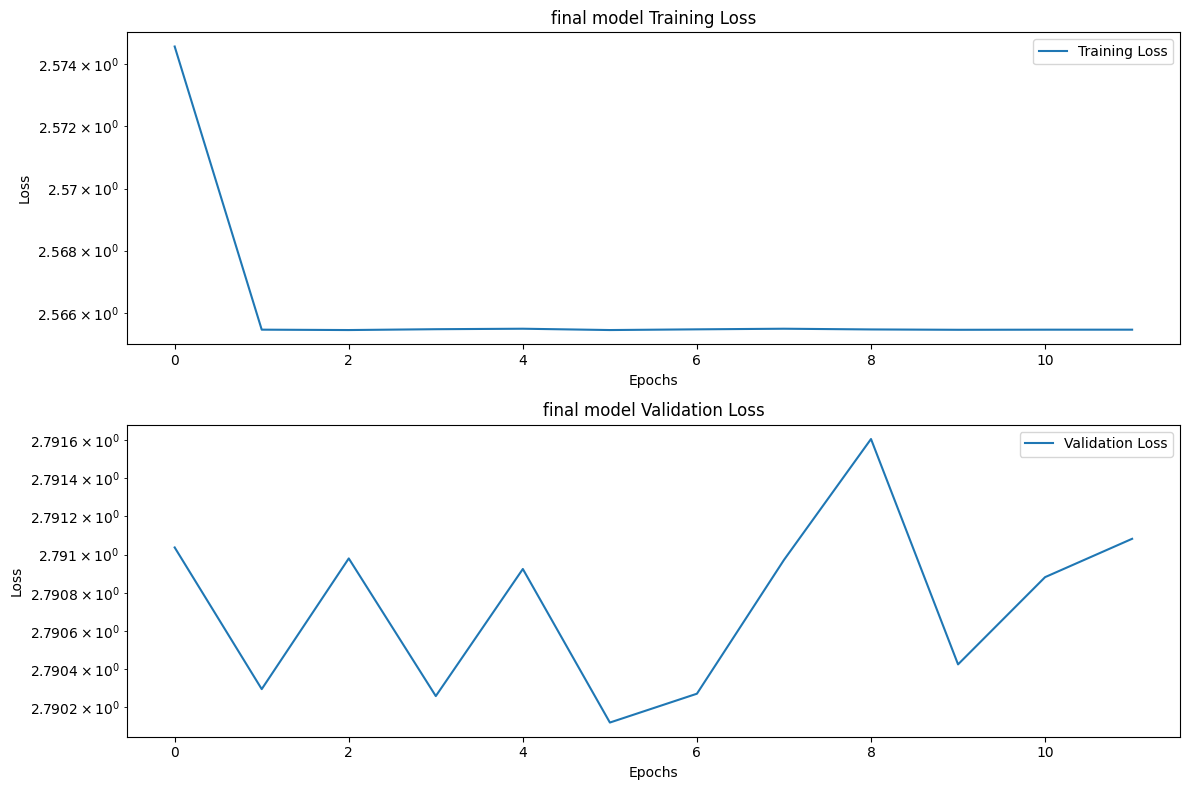

In [ ]:
plot_loss(history_1, 'final model')

In [ ]:
y_pred = final_model.predict([static_test, test_dynamic])

70999/70999 [==============================] - 152s 2ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mae

2.489964458829908

In [ ]:
abs_error = np.abs(y_test - y_pred.flatten())

In [ ]:
abs_error

0          40.004148
1           0.195852
2           0.215852
3           0.165852
4           4.024148
             ...    
2271943     1.114148
2271944     0.135852
2271945     0.205852
2271946     0.195852
2271947     0.205852
Name: PRECTOT, Length: 2271948, dtype: float64

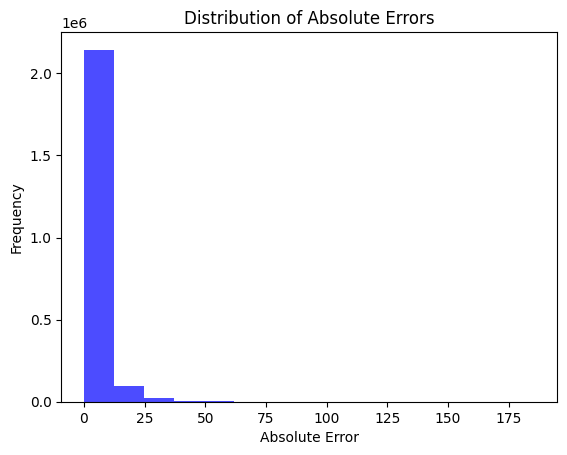

In [ ]:
plt.hist(abs_error, bins=15, color='blue', alpha=0.7)


plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')

plt.show()

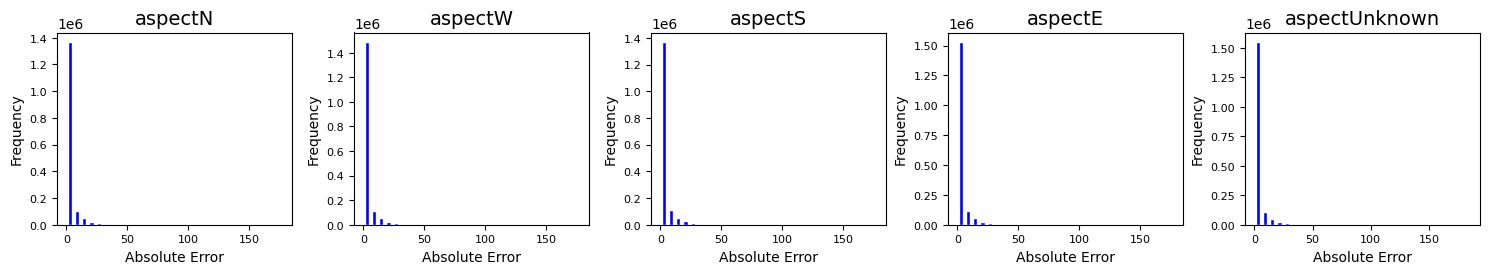

In [ ]:
region_columns = ['aspectN', 'aspectW', 'aspectS', 'aspectE', 'aspectUnknown']

threshold = 0.1

fig, axes = plt.subplots(nrows=1, ncols=len(region_columns), figsize=(15, 3))
axes = axes.flatten()

for i, region in enumerate(region_columns):
    idx = static_test[region] > threshold
    region_indices = static_test[idx].index

    if idx.sum() == 0 or np.isnan(abs_error[region_indices]).all():
        axes[i].set_title(f"{region} - No Data", fontsize=14)
        continue

    axes[i].hist(abs_error[region_indices], bins=30, histtype="barstacked", color="blue", rwidth=0.6, edgecolor="white")
    axes[i].set_title(f"{region}", fontsize=14)
    axes[i].set_xlabel("Absolute Error", fontsize=10)
    axes[i].set_ylabel("Frequency", fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

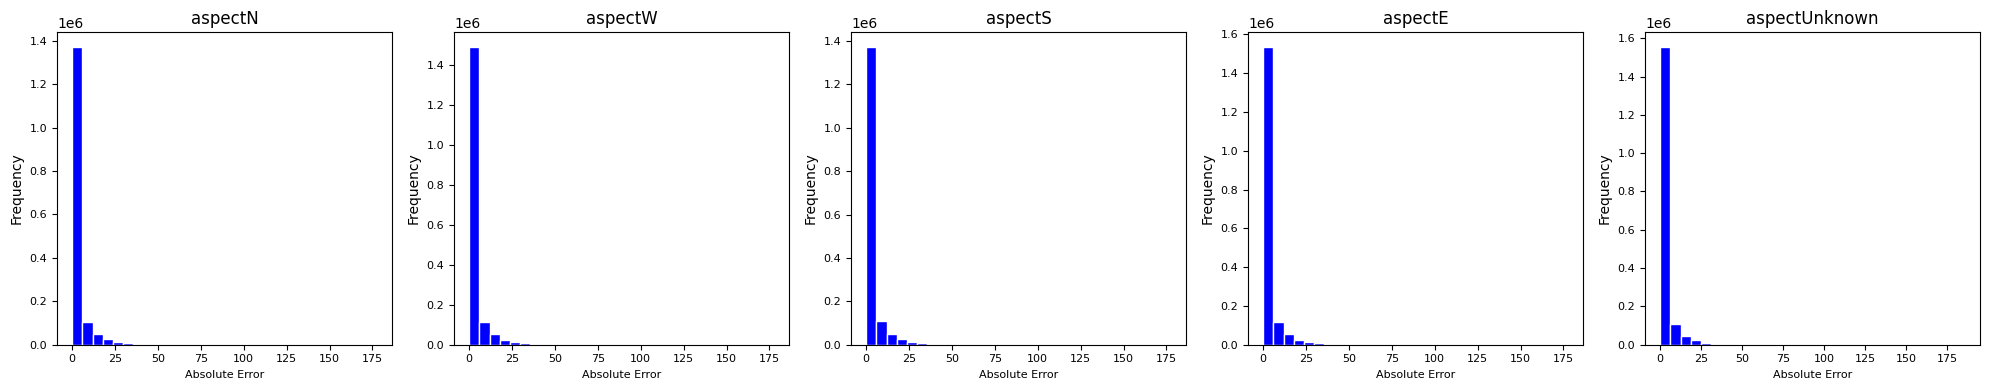

In [ ]:
region_columns = ['aspectN', 'aspectW', 'aspectS', 'aspectE', 'aspectUnknown']

threshold = 0.1

fig, axes = plt.subplots(nrows=1, ncols=len(region_columns), figsize=(20, 4))
axes = axes.flatten()

for i, region in enumerate(region_columns):
    idx = static_test[region] > threshold
    region_indices = static_test[idx].index

    if idx.sum() == 0 or np.isnan(abs_error[region_indices]).all():
        axes[i].set_title(f"{region} - No Data", fontsize=14)
        axes[i].grid(False)
        continue

    axes[i].hist(abs_error[region_indices], bins=30, histtype="barstacked", color="blue", edgecolor="white")
    axes[i].set_title(f"{region}", fontsize=12)
    axes[i].set_xlabel("Absolute Error", fontsize=8)
    axes[i].set_ylabel("Frequency", fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)
    axes[i].grid(False)

plt.tight_layout()
plt.show()

In [ ]:
static_pred = static_model.predict(static_test)
static_mae = mean_absolute_error(y_test, static_pred)
static_mse = mean_squared_error(y_test, static_pred)
static_r2 = r2_score(y_test, static_pred)

70999/70999 [==============================] - 84s 1ms/step


In [ ]:
static_pred

array([[-0.05733135],
       [-0.05733135],
       [-0.05733135],
       ...,
       [-0.05733135],
       [-0.05733135],
       [-0.05733135]], dtype=float32)

In [ ]:
static_mae

2.556438684699699

In [ ]:
dynamic_pred = dynamic_model.predict(test_dynamic)
dynamic_mae = mean_absolute_error(y_test, dynamic_pred)
dynamic_mse = mean_squared_error(y_test, dynamic_pred)
dynamic_r2 = r2_score(y_test, dynamic_pred)

70999/70999 [==============================] - 130s 2ms/step


In [ ]:
dynamic_mae

2.4963509938865167

In [ ]:
combined_mae = mean_absolute_error(y_test, test_predictions)
combined_mae

2.489964458829908

70999/70999 [==============================] - 129s 2ms/step


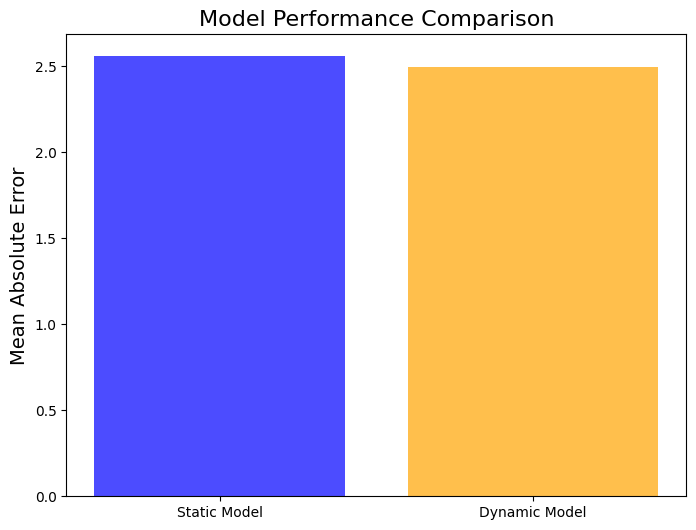

In [ ]:
static_mae = mean_absolute_error(y_test, static_model.predict(static_test))
dynamic_mae = mean_absolute_error(y_test, dynamic_model.predict(test_dynamic))

mae_values = [static_mae, dynamic_mae]

colors = ['blue', 'orange']

plt.figure(figsize=(8, 6))
plt.bar(['Static Model', 'Dynamic Model'], mae_values, color=colors, alpha=0.7)

plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Model Performance Comparison', fontsize=16)

plt.show()

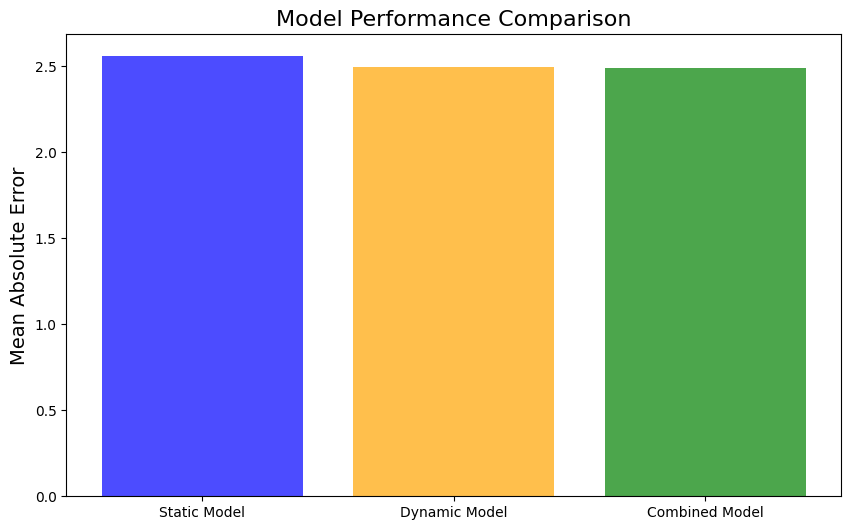

In [ ]:
mae_values = [static_mae, dynamic_mae, combined_mae]

colors = ['blue', 'orange', 'green']

plt.figure(figsize=(10, 6))
plt.bar(['Static Model', 'Dynamic Model', 'Combined Model'], mae_values,color=colors, alpha=0.7)

plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Model Performance Comparison', fontsize=16)

plt.show()

In [ ]:
print(static_test.columns)

Index(['fips', 'lat', 'lon', 'elevation', 'slope1', 'slope2', 'slope3',
       'slope4', 'slope5', 'slope6', 'slope7', 'slope8', 'aspectN', 'aspectE',
       'aspectS', 'aspectW', 'aspectUnknown', 'WAT_LAND', 'NVG_LAND',
       'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND',
       'CULT_LAND', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7'],
      dtype='object')


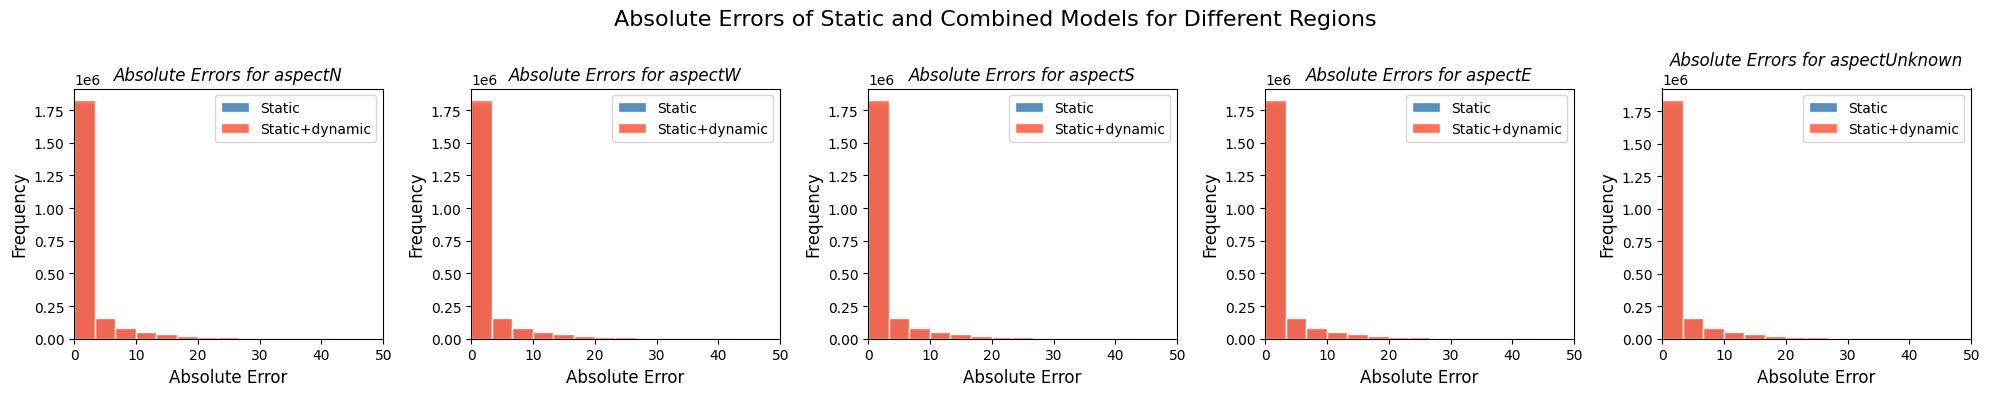

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(region_columns), figsize=(20, 4))

for i, region in enumerate(region_columns):
    idx = static_test[region] > 0

    abs_error_static = np.abs(y_test[idx] - static_pred.flatten()[idx])
    abs_error_combined = np.abs(y_test[idx] - y_pred.flatten()[idx])

    axes[i].hist(abs_error_static, bins=15, color="steelblue", edgecolor="white", label='Static', range=(0, 50), alpha=0.9)

    axes[i].hist(abs_error_combined, bins=15, color="tomato", edgecolor="white", label='Static+dynamic', range=(0, 50), alpha=0.9)

    axes[i].set_title(f"Absolute Errors for {region}", fontsize=12, style='italic')
    axes[i].set_xlabel("Absolute Error", fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)

    axes[i].set_xlim(0, 50)

    axes[i].legend()

plt.suptitle('Absolute Errors of Static and Combined Models for Different Regions', fontsize=16)

plt.tight_layout()
plt.show()


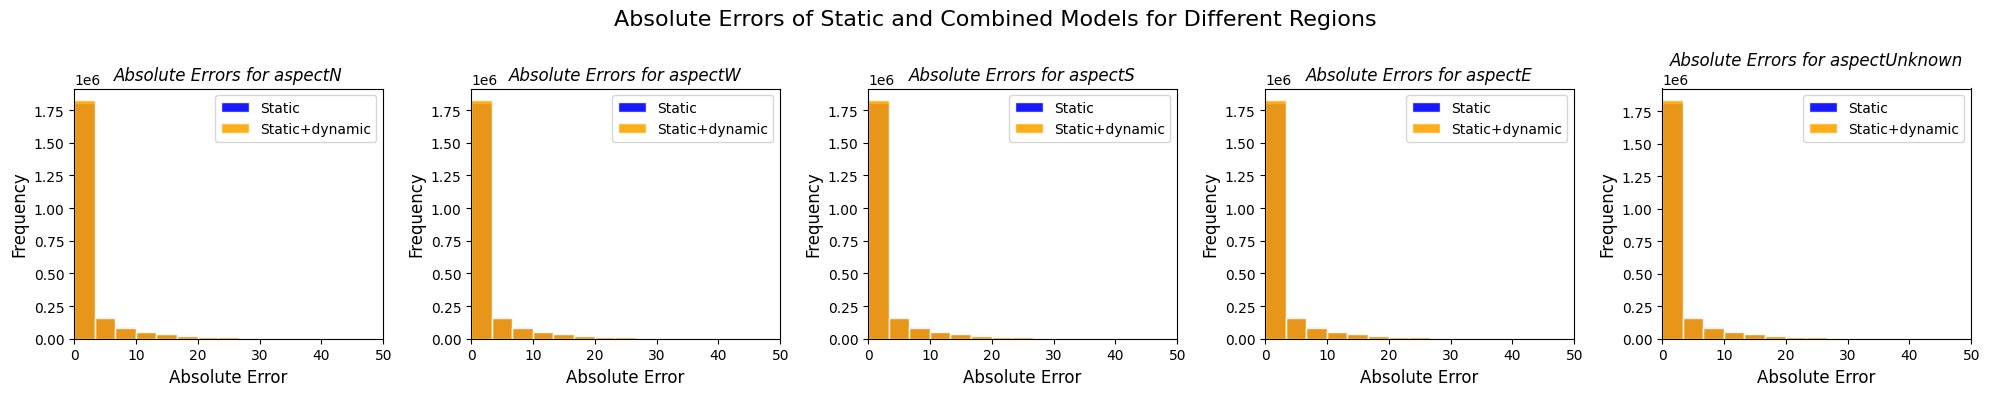

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(region_columns), figsize=(20, 4))

for i, region in enumerate(region_columns):
    idx = static_test[region] > 0

    abs_error_static = np.abs(y_test[idx] - static_pred.flatten()[idx])
    abs_error_combined = np.abs(y_test[idx] - y_pred.flatten()[idx])

    axes[i].hist(abs_error_static, bins=15, color="blue", edgecolor="white", label='Static', range=(0, 50), alpha=0.9)

    axes[i].hist(abs_error_combined, bins=15, color="orange", edgecolor="white", label='Static+dynamic', range=(0, 50), alpha=0.9)

    axes[i].set_title(f"Absolute Errors for {region}", fontsize=12, style='italic')
    axes[i].set_xlabel("Absolute Error", fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)

    axes[i].set_xlim(0, 50)

    axes[i].legend()

plt.suptitle('Absolute Errors of Static and Combined Models for Different Regions', fontsize=16)

plt.tight_layout()
plt.show()
